In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt

from loader import All_fundus_files
from networks import weights_init, Discriminator_128_v2_PatchGAN, Flatten

dataroot = "data/fundus2/"
batch_size = 64
image_size = 128 #size using data aug.
num_classes = 5

ch_out = 3 
#ch_noise = 100
#ch_g = 64
ch_d = 64

num_epochs = 500
lr = 0.0002
beta1 = 0.5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device == 'cuda':
    cudnn.benchmark = True

cuda


In [3]:
# Data
transform_train = transforms.Compose([
    #transforms.RandomResizedCrop(image_size),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.ImageFolder(root=dataroot+'sorted', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

testset = torchvision.datasets.ImageFolder(root=dataroot+'val', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

classes = testset.classes
print(trainset.classes)
print(testset.class_to_idx)
print(len(trainset), len(testset))

['catergory00', 'catergory01', 'catergory02', 'catergory03', 'catergory04']
{'catergory00': 0, 'catergory01': 1, 'catergory02': 2, 'catergory03': 3, 'catergory04': 4}
3462 200


In [16]:
# Model
net = Discriminator_128_v2_PatchGAN(ch_out, ch_d)
net.backbone[14] = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    Flatten(),
    nn.Linear(in_features=ch_d * 16, out_features=num_classes, bias=True)
)
net.pooling = nn.Identity()
net = net.to(device)
net.apply(weights_init)
print(net)

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if True:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/exp6/ckpt.pth')
    msg = net.load_state_dict(checkpoint['net'], strict=False)
    assert set(msg.missing_keys) == {"backbone.14.2.weight", "backbone.14.2.bias"}, 'missing_keys: {}'.format(set(msg.missing_keys))
    assert set(msg.unexpected_keys) == {"backbone.14.weight"}, 'unexpected_keys: {}'.format(set(msg.unexpected_keys))
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    print(best_acc,start_epoch)
    
    #for name, param in net.named_parameters():
    #    if name not in ["backbone.11.weight", "backbone.12.weight", "backbone.12.bias", "backbone.15.1.weight", "backbone.15.1.bias"]:
    #        param.requires_grad = False
    #    else:
    #        print('{}'.format(name))
    '''
    backbone.0.weight
    backbone.2.weight
    backbone.5.weight
    backbone.8.weight
    backbone.11.weight
    backbone.14.2.weight
    backbone.14.2.bias
    '''
    # check
    parameters = list(filter(lambda p: p.requires_grad, net.parameters()))
    assert len(parameters) == 7


# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters, lr=lr, betas=(beta1, 0.999))
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [100,250], gamma=0.1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


Discriminator_128_v2_PatchGAN(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  

In [17]:
from torchsummary import summary
summary(net, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
    InstanceNorm2d-4          [-1, 128, 32, 32]               0
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
    InstanceNorm2d-7          [-1, 256, 16, 16]               0
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
   InstanceNorm2d-10            [-1, 512, 8, 8]               0
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 7, 7]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 7, 7]               0
        LeakyReLU-14           [-1, 102

In [18]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train Loss: %.3f | Acc: %.3f%% (%d/%d)' %(train_loss / (batch_idx+1), 100.*correct/total, correct, total))
    return train_loss /(batch_idx+1), correct/total

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print('Test Loss: %.3f | Acc: %.3f%% (%d/%d)' %(test_loss /(batch_idx+1), 100.*correct/total, correct, total))
    return test_loss /(batch_idx+1), correct/total

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint/exp3'):
            os.mkdir('checkpoint/exp3')
        torch.save(state, './checkpoint/exp3/ckpt.pth')
        best_acc = acc

Train_losses = []
Test_losses = []
Train_acc = []
Test_acc = []
for epoch in range(start_epoch, start_epoch+num_epochs):
    ls, acc = train(epoch)
    Train_losses.append(ls)
    Train_acc.append(acc)
    
    ls, acc = test(epoch)
    Test_losses.append(ls)
    Test_acc.append(acc)
    
    scheduler.step()


Epoch: 100
Train Loss: 1.019 | Acc: 66.320% (2296/3462)
Test Loss: 1.711 | Acc: 36.000% (72/200)

Epoch: 101
Train Loss: 0.828 | Acc: 72.819% (2521/3462)
Test Loss: 1.668 | Acc: 41.500% (83/200)

Epoch: 102
Train Loss: 0.765 | Acc: 73.541% (2546/3462)
Test Loss: 1.677 | Acc: 37.500% (75/200)

Epoch: 103
Train Loss: 0.742 | Acc: 74.206% (2569/3462)
Test Loss: 1.706 | Acc: 37.000% (74/200)

Epoch: 104
Train Loss: 0.732 | Acc: 74.090% (2565/3462)
Test Loss: 1.478 | Acc: 46.500% (93/200)

Epoch: 105
Train Loss: 0.725 | Acc: 74.812% (2590/3462)
Test Loss: 1.615 | Acc: 38.000% (76/200)

Epoch: 106
Train Loss: 0.702 | Acc: 74.726% (2587/3462)
Test Loss: 1.642 | Acc: 41.500% (83/200)

Epoch: 107
Train Loss: 0.697 | Acc: 75.246% (2605/3462)
Test Loss: 1.544 | Acc: 46.000% (92/200)

Epoch: 108
Train Loss: 0.692 | Acc: 75.101% (2600/3462)
Test Loss: 1.594 | Acc: 44.500% (89/200)

Epoch: 109
Train Loss: 0.690 | Acc: 75.332% (2608/3462)
Test Loss: 1.459 | Acc: 45.000% (90/200)

Epoch: 110
Train Lo

Test Loss: 1.682 | Acc: 52.500% (105/200)

Epoch: 184
Train Loss: 0.180 | Acc: 95.494% (3306/3462)
Test Loss: 1.770 | Acc: 51.000% (102/200)

Epoch: 185
Train Loss: 0.194 | Acc: 95.350% (3301/3462)
Test Loss: 1.561 | Acc: 48.500% (97/200)

Epoch: 186
Train Loss: 0.190 | Acc: 95.321% (3300/3462)
Test Loss: 1.672 | Acc: 54.000% (108/200)

Epoch: 187
Train Loss: 0.166 | Acc: 96.187% (3330/3462)
Test Loss: 1.374 | Acc: 55.000% (110/200)

Epoch: 188
Train Loss: 0.152 | Acc: 96.592% (3344/3462)
Test Loss: 1.379 | Acc: 51.500% (103/200)

Epoch: 189
Train Loss: 0.157 | Acc: 96.418% (3338/3462)
Test Loss: 2.182 | Acc: 51.500% (103/200)

Epoch: 190
Train Loss: 0.153 | Acc: 96.534% (3342/3462)
Test Loss: 1.280 | Acc: 58.500% (117/200)

Epoch: 191
Train Loss: 0.133 | Acc: 97.603% (3379/3462)
Test Loss: 1.729 | Acc: 49.000% (98/200)

Epoch: 192
Train Loss: 0.132 | Acc: 97.198% (3365/3462)
Test Loss: 1.138 | Acc: 61.000% (122/200)

Epoch: 193
Train Loss: 0.134 | Acc: 97.140% (3363/3462)
Test Loss: 1

Test Loss: 1.701 | Acc: 55.000% (110/200)

Epoch: 267
Train Loss: 0.030 | Acc: 99.047% (3429/3462)
Test Loss: 1.863 | Acc: 52.500% (105/200)

Epoch: 268
Train Loss: 0.027 | Acc: 99.162% (3433/3462)
Test Loss: 1.872 | Acc: 55.500% (111/200)

Epoch: 269
Train Loss: 0.026 | Acc: 99.133% (3432/3462)
Test Loss: 1.468 | Acc: 61.000% (122/200)

Epoch: 270
Train Loss: 0.031 | Acc: 99.076% (3430/3462)
Test Loss: 1.961 | Acc: 50.000% (100/200)

Epoch: 271
Train Loss: 0.026 | Acc: 99.162% (3433/3462)
Test Loss: 1.924 | Acc: 53.500% (107/200)

Epoch: 272
Train Loss: 0.026 | Acc: 99.105% (3431/3462)
Test Loss: 1.840 | Acc: 56.000% (112/200)

Epoch: 273
Train Loss: 0.025 | Acc: 99.162% (3433/3462)
Test Loss: 1.820 | Acc: 56.000% (112/200)

Epoch: 274
Train Loss: 0.030 | Acc: 98.902% (3424/3462)
Test Loss: 2.161 | Acc: 51.000% (102/200)

Epoch: 275
Train Loss: 0.029 | Acc: 98.960% (3426/3462)
Test Loss: 1.967 | Acc: 54.500% (109/200)

Epoch: 276
Train Loss: 0.030 | Acc: 98.960% (3426/3462)
Test Loss:

Test Loss: 2.339 | Acc: 53.500% (107/200)

Epoch: 350
Train Loss: 0.020 | Acc: 98.960% (3426/3462)
Test Loss: 2.213 | Acc: 53.000% (106/200)

Epoch: 351
Train Loss: 0.017 | Acc: 99.191% (3434/3462)
Test Loss: 2.226 | Acc: 53.500% (107/200)

Epoch: 352
Train Loss: 0.022 | Acc: 98.845% (3422/3462)
Test Loss: 1.917 | Acc: 57.500% (115/200)

Epoch: 353
Train Loss: 0.022 | Acc: 98.816% (3421/3462)
Test Loss: 2.190 | Acc: 53.500% (107/200)

Epoch: 354
Train Loss: 0.021 | Acc: 98.989% (3427/3462)
Test Loss: 2.036 | Acc: 53.000% (106/200)

Epoch: 355
Train Loss: 0.020 | Acc: 98.902% (3424/3462)
Test Loss: 2.291 | Acc: 52.500% (105/200)

Epoch: 356
Train Loss: 0.018 | Acc: 99.133% (3432/3462)
Test Loss: 2.301 | Acc: 53.500% (107/200)

Epoch: 357
Train Loss: 0.019 | Acc: 98.960% (3426/3462)
Test Loss: 2.351 | Acc: 53.000% (106/200)

Epoch: 358
Train Loss: 0.019 | Acc: 98.989% (3427/3462)
Test Loss: 2.193 | Acc: 55.000% (110/200)

Epoch: 359
Train Loss: 0.018 | Acc: 99.220% (3435/3462)
Test Loss:

Test Loss: 2.297 | Acc: 55.500% (111/200)

Epoch: 433
Train Loss: 0.015 | Acc: 99.220% (3435/3462)
Test Loss: 2.274 | Acc: 54.000% (108/200)

Epoch: 434
Train Loss: 0.016 | Acc: 99.047% (3429/3462)
Test Loss: 2.513 | Acc: 55.500% (111/200)

Epoch: 435
Train Loss: 0.013 | Acc: 99.422% (3442/3462)
Test Loss: 2.496 | Acc: 54.500% (109/200)

Epoch: 436
Train Loss: 0.018 | Acc: 98.902% (3424/3462)
Test Loss: 2.467 | Acc: 55.000% (110/200)

Epoch: 437
Train Loss: 0.017 | Acc: 98.960% (3426/3462)
Test Loss: 2.506 | Acc: 54.500% (109/200)

Epoch: 438
Train Loss: 0.015 | Acc: 99.220% (3435/3462)
Test Loss: 2.608 | Acc: 53.500% (107/200)

Epoch: 439
Train Loss: 0.016 | Acc: 99.018% (3428/3462)
Test Loss: 2.349 | Acc: 53.500% (107/200)

Epoch: 440
Train Loss: 0.015 | Acc: 99.018% (3428/3462)
Test Loss: 2.378 | Acc: 55.000% (110/200)

Epoch: 441
Train Loss: 0.016 | Acc: 99.018% (3428/3462)
Test Loss: 2.577 | Acc: 53.500% (107/200)

Epoch: 442
Train Loss: 0.014 | Acc: 99.278% (3437/3462)
Test Loss:

Test Loss: 2.556 | Acc: 55.500% (111/200)

Epoch: 516
Train Loss: 0.014 | Acc: 99.162% (3433/3462)
Test Loss: 2.577 | Acc: 54.000% (108/200)

Epoch: 517
Train Loss: 0.013 | Acc: 99.162% (3433/3462)
Test Loss: 2.536 | Acc: 55.000% (110/200)

Epoch: 518
Train Loss: 0.014 | Acc: 98.989% (3427/3462)
Test Loss: 2.482 | Acc: 55.000% (110/200)

Epoch: 519
Train Loss: 0.014 | Acc: 98.873% (3423/3462)
Test Loss: 2.496 | Acc: 55.000% (110/200)

Epoch: 520
Train Loss: 0.014 | Acc: 99.076% (3430/3462)
Test Loss: 2.483 | Acc: 55.500% (111/200)

Epoch: 521
Train Loss: 0.012 | Acc: 99.307% (3438/3462)
Test Loss: 2.521 | Acc: 55.500% (111/200)

Epoch: 522
Train Loss: 0.013 | Acc: 99.162% (3433/3462)
Test Loss: 2.546 | Acc: 55.000% (110/200)

Epoch: 523
Train Loss: 0.012 | Acc: 99.220% (3435/3462)
Test Loss: 2.503 | Acc: 55.000% (110/200)

Epoch: 524
Train Loss: 0.014 | Acc: 99.105% (3431/3462)
Test Loss: 2.476 | Acc: 55.000% (110/200)

Epoch: 525
Train Loss: 0.014 | Acc: 99.105% (3431/3462)
Test Loss:

Test Loss: 2.583 | Acc: 56.000% (112/200)

Epoch: 599
Train Loss: 0.013 | Acc: 99.133% (3432/3462)
Test Loss: 2.583 | Acc: 56.000% (112/200)


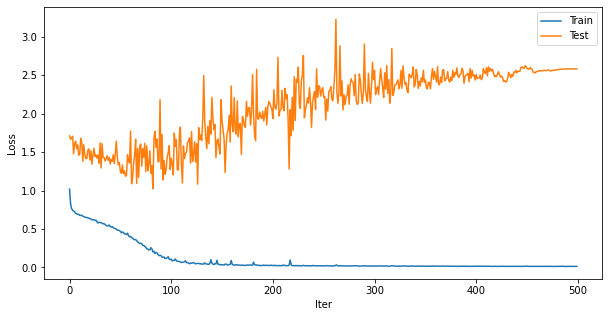

In [19]:
# check loss
plt.figure(figsize=(10,5))
plt.plot(Train_losses,label="Train")
plt.plot(Test_losses,label="Test")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

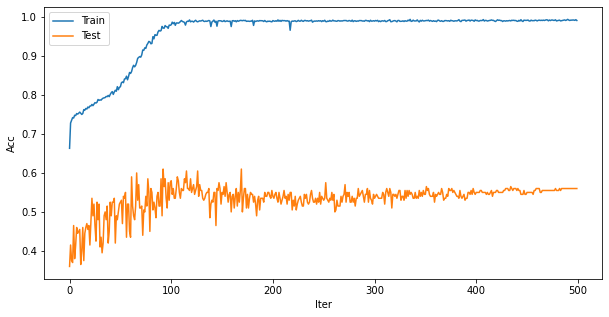

In [20]:
# check acc
plt.figure(figsize=(10,5))
plt.plot(Train_acc,label="Train")
plt.plot(Test_acc,label="Test")
plt.xlabel("Iter")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [21]:
def test_only():
    net.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))
    return (100 * correct / total)

acc = test_only() 

Accuracy of the network on the 10000 test images: 56.000000 %


In [22]:
def test_each_class():
    net.eval()
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels =images.to(device), labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    #label = int(label.cpu().numpy())
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.2f} %".format(classname,
        accuracy))

test_each_class()

Accuracy for class catergory00 is: 97.50 %
Accuracy for class catergory01 is: 57.50 %
Accuracy for class catergory02 is: 85.00 %
Accuracy for class catergory03 is: 25.00 %
Accuracy for class catergory04 is: 15.00 %


In [ ]:
# save
state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
#torch.save(state, './checkpoint/ckpt_fin.pth')

In [ ]:
# load
resume = 'ckpt'
checkpoint = torch.load('./checkpoint/'+resume+'.pth')
#net.load_state_dict(checkpoint['net'])

In [ ]:
acc = test_only() 
test_each_class()